# Extract and Process hadntrack data Notebook
## Steps
1) Load raw handtrack/cam data
2) Do ts/cam lag review
3) Apply final processing steps (spatial regression and/or plotting)

Deps:
- pythonlib
- pyvm
    - with updated pyvm globals refelcting proper dirs
- drawmonkey, ideally as a env package

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from pyvm.tools.preprocess import loadSingleDataQuick
from pyvm.globals import BASEDIR
from drawmonkey.tools.handtrack import HandTrack
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [16]:
#Basedir used by pipeline to find data and other stuff. Normally the basedir in pyvm globals is updated when pipeline
#shell scripts are run. In this case that will not happen, so this will need updated manually in pyvm.globals to be where
#ht data is stored
print(BASEDIR)

/home/danhan/freiwaldDrive/dhanuska/hand_track


### STEP 1
Load HT data

In [ ]:
## Load handtrack data
animal,date,expt,sess,sess_print = ('Diego','230913','dirgrammardiego5d','1','')
fd = loadSingleDataQuick(animal, date, expt, sess)
#Idk why this happens 
fd['params']['sample_rate'] = fd['params']['sample_rate'][0]

ind1_vid = 0
ind1_ml2 = 0
HT = HandTrack(ind1_vid,ind1_ml2,fd,date,expt,animal,sess_print)
HT.load_campy_data(ind1_ml2)

OUTDICT {'base_dir': ['/home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl'], 'base_dir_server': ['/home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl'], 'base_dir_server_2': []}
OUTDICT {'base_dir': ['/home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl'], 'base_dir_server': ['/home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl'], 'base_dir_server_2': []}
-- loaded presaved data: /home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl
OUTDICT {'base_dir': ['/home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl'], 'base_dir_server': ['/home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl'], 'base_dir_server_2': []}


In [22]:
#Coefs available for this day
print(HT.Coefs)

#HT class function automatically run for both coefs, but allow user to manually choose
coefs = '220914_f12_dlc'

['220914_f12_dlc', '220914_flea_bfs1_dlc']


In [56]:
#Process data function
#Load if processed data already saved, else skip.

#Range of trials, 1 indexed
trange = range(10,20)

data_dir = f'{BASEDIR}/{animal}/{date}_{expt}{sess_print}'
skip_load = False
if os.path.exists(f'{data_dir}/processed_data.pkl') and not skip_load:
    with open(f'{data_dir}/processed_data.pkl','rb') as f:
        dat_trials = pickle.load(f)
else:
    #Maintain dict structure expected later
    dat_trials = {}
    dat_trials[coefs] = {}
    skipped_trials = []
    #Better to just do try except bc this takes a while and some, very infrequent, errors occur
    for trial_ml2 in trange:
        try:
            dat_trials[coefs][trial_ml2],_,_,= HT.process_data_singletrial(trial_ml2, coefs=coefs)
        except:
            skipped_trials.append(trial_ml2)

In [62]:
#Shorten to trange but maintain dict structure
dat_trials_short = {}
dat_trials_short[coefs] = {}
for trial,dat in dat_trials[coefs].items():
    if trial in trange:
        dat_trials_short[coefs][trial] = dat

### STEP 2
Do lag stuff

In [64]:
from pythonlib.tools.camtools import get_lags,finalize_alignment_data
#Where to save plots from lag fxn
outdir = f'{data_dir}/lags/{coefs}'
print(outdir)
lags={}
lags['corr_lags'] = get_lags(dat_trials_short,outdir,coefs,True)

/home/danhan/freiwaldDrive/dhanuska/hand_track/Diego/230913_dirgrammardiego5d/lags/220914_f12_dlc
(1004, 2)
(987, 2)
(1000, 2)
(985, 2)
(995, 2)
(998, 2)
(983, 2)
(994, 2)
(1018, 2)


Now go to outdir (data_dir/lags/coefs) and find the inds of good lags to take for final calculation

10-0 0.013443923360590304
12-0 0.010499415391156397
15-0 0.01728455774250115
16-0 -0.005494122706421578
17-0 0.011335450798159563
18-0 0.013389106936044115


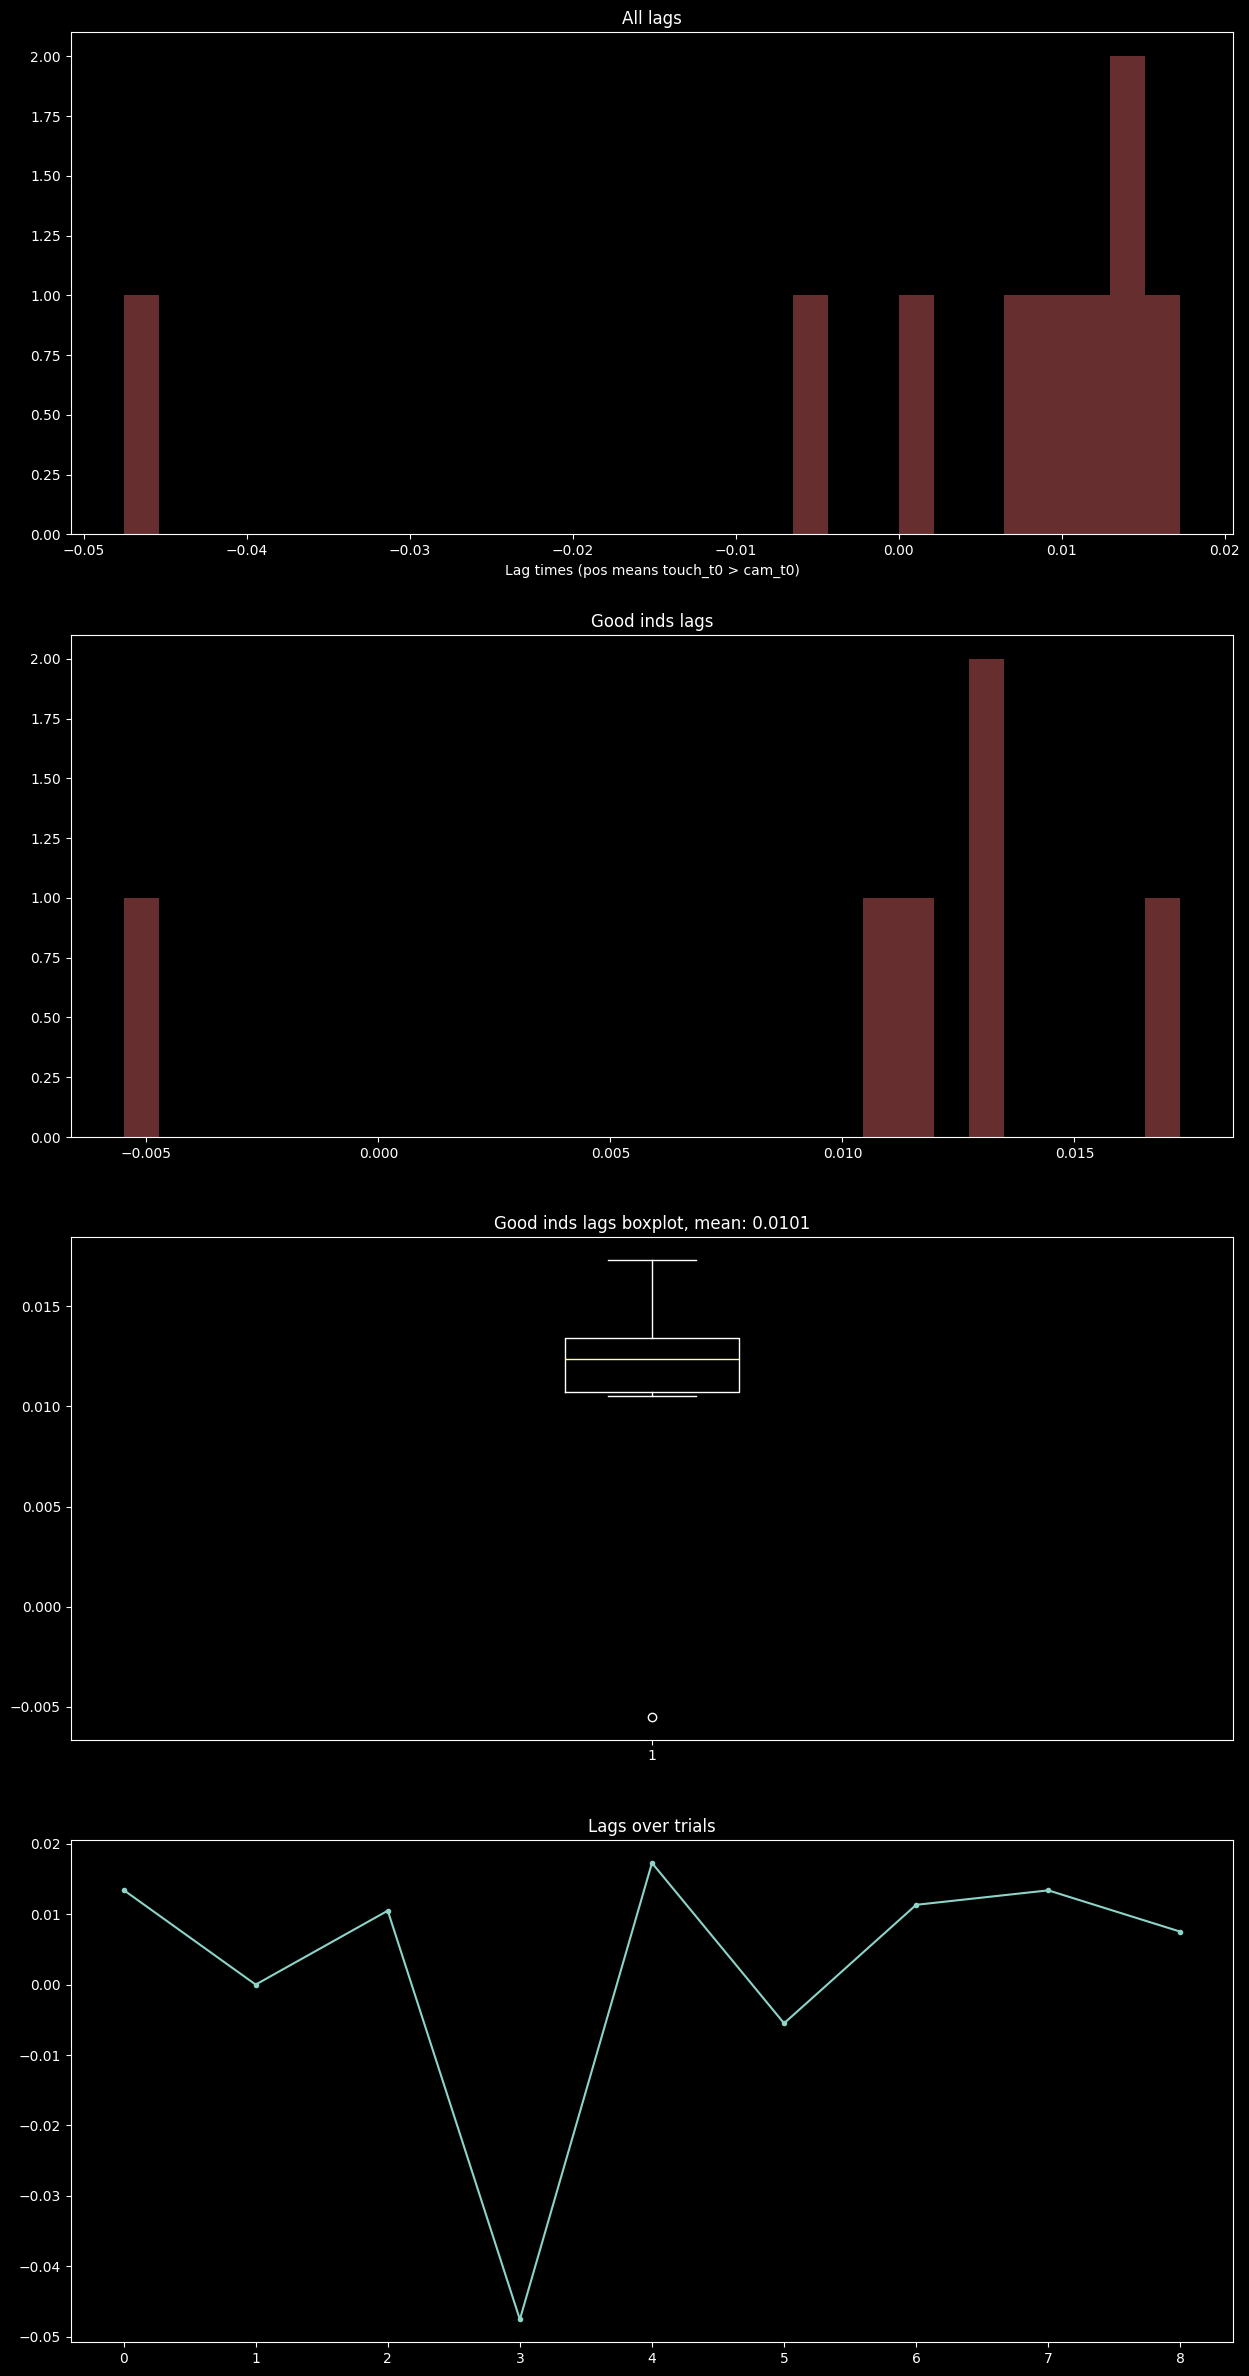

In [65]:
#Take index convention from the file name-- 'trial-stroke'
good_inds = ['10-0','12-0','15-0','16-0','17-0','18-0']
fig,corr_lag_mean = finalize_alignment_data(lags,good_inds)
fig.savefig(f'{outdir}/lag_fig.png')

### STEP 3
Load HT data again with regression and new lag num

In [55]:
dat_trials_lag = {}
skipped_trials = []
#Now can fit regression
HT.fit_regression(trange,corr_lag_mean,coefs,out=f'{data_dir}/transforms')

# assert corr_lag_mean > 0

for trial_ml2 in trange:
    try:
        #Will automatically adapt to include regressed data
        dat_trials_lag[trial_ml2],_,_,= HT.process_data_singletrial(trial_ml2, coefs=coefs,ts_cam_offset=corr_lag_mean)
        plt.close('all')
    except:
        skipped_trials.append(trial_ml2)

Not doing regression because reg file already exists, delete if you want to rerun the regression. Running step 4 again automatically removes it.
Not doing regression because reg file already exists, delete if you want to rerun the regression. Running step 4 again automatically removes it.
Not doing regression because reg file already exists, delete if you want to rerun the regression. Running step 4 again automatically removes it.
Searching using this string:
/home/danhan/freiwaldDrive/dhanuska/hand_track/Diego/230913_dirgrammardiego5d/behavior/220914_f12_dlc_extracted_dlc_data/*camera*trial_10-*dat**
Found this many paths:
2
---
/home/danhan/freiwaldDrive/dhanuska/hand_track/Diego/230913_dirgrammardiego5d/behavior/220914_f12_dlc_extracted_dlc_data/camera_fly1_-trial_10-dat.pkl
---
/home/danhan/freiwaldDrive/dhanuska/hand_track/Diego/230913_dirgrammardiego5d/behavior/220914_f12_dlc_extracted_dlc_data/camera_fly2_-trial_10-dat.pkl
###DOING REGRESSION ON CAM PTS###
Searching using this s